# 🧺 Análise de Cesta - Algoritmo FP Growth

### 🔣 Dicionário de Dados

**Legenda das Colunas da Tabela de Regras de Associação**

* **`antecedents`**:
    * O(s) código(s) do(s) produto(s) no lado esquerdo da regra (item X em "SE compra X...").
    * Tipo: Texto (object) ou Número (int64), idealmente tratado como Texto.

* **`consequents`**:
    * O(s) código(s) do(s) produto(s) no lado direito da regra (item Y em "...ENTÃO compra Y").
    * Tipo: Texto (object) ou Número (int64), idealmente tratado como Texto.

* **`antecedent support`**:
    * Frequência/proporção de transações que contêm o antecedente (X). `P(X)`.
    * Tipo: Número Decimal (float64). *Formatar como Percentual (%) para visualização.*

* **`consequent support`**:
    * Frequência/proporção de transações que contêm o consequente (Y). `P(Y)`.
    * Tipo: Número Decimal (float64). *Formatar como Percentual (%) para visualização.*

* **`support`**:
    * Frequência/proporção de transações que contêm *tanto* o antecedente (X) *quanto* o consequente (Y). `P(X e Y)`.
    * Indica a popularidade geral da *combinação* X e Y.
    * Tipo: Número Decimal (float64). *Formatar como Percentual (%) para visualização.*

* **`confidence`**:
    * Probabilidade de encontrar o consequente (Y) em uma transação, *dado que* ela já contém o antecedente (X). `P(Y | X)`.
    * Mede a *confiabilidade* ou força preditiva da regra na direção X -> Y.
    * Tipo: Número Decimal (float64). *Formatar como Percentual (%) para visualização.*

* **`lift`**:
    * Mede quantas vezes a presença de X *aumenta* a probabilidade de comprar Y, comparado à probabilidade normal de comprar Y. `Conf(X->Y) / Sup(Y)`.
    * Lift > 1 indica associação positiva (interessante); Lift = 1 indica independência; Lift < 1 indica associação negativa.
    * Tipo: Número Decimal (float64). *Formatar como Número Decimal (ex: 2 casas).*

* **`representativity`**: (Atenção: Métrica menos padronizada, pode ter definições variadas)
    * Tenta medir quão "representativa" é a regra ou a dependência encontrada, possivelmente comparando métricas observadas com esperadas.
    * *Verificar a documentação da biblioteca usada ou a fórmula específica para interpretação precisa.*
    * Tipo: Número Decimal (float64). *Formatar como Número Decimal.*

* **`leverage`**:
    * Mede a diferença entre a frequência observada de X e Y juntos e a frequência esperada se fossem independentes. `Sup(X,Y) - Sup(X)*Sup(Y)`.
    * Valores > 0 indicam que aparecem juntos mais que o esperado.
    * Tipo: Número Decimal (float64). *Formatar como Número Decimal.*

* **`conviction`**:
    * Mede o grau de "implicação" da regra. Alto valor sugere que o consequente depende fortemente do antecedente. `(1-Sup(Y))/(1-Conf(X->Y))`.
    * Pode ser muito alto ou infinito.
    * Tipo: Número Decimal (float64). *Formatar como Número Decimal.*

* **`zhangs_metric`**:
    * Métrica robusta (varia de -1 a +1) que mede a associação levando em conta suporte e confiança, sem ser afetada pela popularidade isolada.
    * Valores próximos de +1 indicam forte associação positiva.
    * Tipo: Número Decimal (float64). *Formatar como Número Decimal.*

* **`jaccard`**:
    * Coeficiente de Jaccard: similaridade entre os conjuntos de transações contendo X e Y. `Sup(X,Y) / (Sup(X)+Sup(Y)-Sup(X,Y))`.
    * Valor entre 0 e 1 (pode ser visto como %).
    * Tipo: Número Decimal (float64). *Formatar como Número Decimal ou Percentual (%).*

* **`certainty`**:
    * Mede o ganho de "certeza" proporcionado pela regra. `(Conf(X->Y) - Sup(Y)) / (1 - Sup(Y))`.
    * Varia de -1 a 1.
    * Tipo: Número Decimal (float64). *Formatar como Número Decimal.*

* **`kulczynski`**:
    * Média das confianças nas duas direções: `0.5 * (Conf(X->Y) + Conf(Y->X))`.
    * Valor entre 0 e 1 (pode ser visto como %).
    * Tipo: Número Decimal (float64). *Formatar como Número Decimal ou Percentual (%).*

* **`Nomes_Antecedents`**:
    * O(s) nome(s) legível(is) do(s) produto(s) antecedente(s).
    * Tipo: Texto (object).

* **`Nomes_Consequents`**:
    * O(s) nome(s) legível(is) do(s) produto(s) consequente(s).
    * Tipo: Texto (object).


### 📚 Packages

In [1]:
import polars as pl
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules, fpgrowth
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.ticker as mtick
import warnings 
import time     

### 🎲 Dataset

- Dados extraídos do Kaggle - [Brazilian E-Commerce Public Dataset by Olist](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce)

In [2]:
orders = pl.read_csv("../data/olist_orders_dataset.csv")
order_items = pl.read_csv("../data/olist_order_items_dataset.csv")
products = pl.read_csv("../data/olist_products_dataset.csv")

In [4]:
order_items.schema

OrderedDict([('order_id', String),
             ('order_item_id', Int64),
             ('product_id', String),
             ('seller_id', String),
             ('shipping_limit_date', String),
             ('price', Float64),
             ('freight_value', Float64)])

In [5]:
orders.schema

OrderedDict([('order_id', String),
             ('customer_id', String),
             ('order_status', String),
             ('order_purchase_timestamp', String),
             ('order_approved_at', String),
             ('order_delivered_carrier_date', String),
             ('order_delivered_customer_date', String),
             ('order_estimated_delivery_date', String)])

In [6]:
products.schema

OrderedDict([('product_id', String),
             ('product_category_name', String),
             ('product_name_lenght', Int64),
             ('product_description_lenght', Int64),
             ('product_photos_qty', Int64),
             ('product_weight_g', Int64),
             ('product_length_cm', Int64),
             ('product_height_cm', Int64),
             ('product_width_cm', Int64)])

### 🧩 E.D.A

In [3]:
orders.head()

order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
str,str,str,str,str,str,str,str
"""e481f51cbdc546…","""9ef432eb625129…","""delivered""","""2017-10-02 10:…","""2017-10-02 11:…","""2017-10-04 19:…","""2017-10-10 21:…","""2017-10-18 00:…"
"""53cdb2fc8bc7dc…","""b0830fb4747a6c…","""delivered""","""2018-07-24 20:…","""2018-07-26 03:…","""2018-07-26 14:…","""2018-08-07 15:…","""2018-08-13 00:…"
"""47770eb9100c2d…","""41ce2a54c0b03b…","""delivered""","""2018-08-08 08:…","""2018-08-08 08:…","""2018-08-08 13:…","""2018-08-17 18:…","""2018-09-04 00:…"
"""949d5b44dbf5de…","""f88197465ea792…","""delivered""","""2017-11-18 19:…","""2017-11-18 19:…","""2017-11-22 13:…","""2017-12-02 00:…","""2017-12-15 00:…"
"""ad21c59c0840e6…","""8ab97904e6daea…","""delivered""","""2018-02-13 21:…","""2018-02-13 22:…","""2018-02-14 19:…","""2018-02-16 18:…","""2018-02-26 00:…"


In [4]:
order_items.head()

order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
str,i64,str,str,str,f64,f64
"""00010242fe8c5a…",1,"""4244733e06e7ec…","""48436dade18ac8…","""2017-09-19 09:…",58.9,13.29
"""00018f77f2f032…",1,"""e5f2d52b802189…","""dd7ddc04e1b6c2…","""2017-05-03 11:…",239.9,19.93
"""000229ec398224…",1,"""c777355d18b72b…","""5b51032eddd242…","""2018-01-18 14:…",199.0,17.87
"""00024acbcdf0a6…",1,"""7634da152a4610…","""9d7a1d34a50524…","""2018-08-15 10:…",12.99,12.79
"""00042b26cf59d7…",1,"""ac6c3623068f30…","""df560393f3a51e…","""2017-02-13 13:…",199.9,18.14


In [5]:
products.head()

product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
str,str,i64,i64,i64,i64,i64,i64,i64
"""1e9e8ef04dbcff…","""perfumaria""",40,287,1,225,16,10,14
"""3aa071139cb16b…","""artes""",44,276,1,1000,30,18,20
"""96bd76ec881037…","""esporte_lazer""",46,250,1,154,18,9,15
"""cef67bcfe19066…","""bebes""",27,261,1,371,26,4,26
"""9dc1a7de274444…","""utilidades_dom…",37,402,4,625,20,17,13


- Shape de cada DF

In [6]:
print(f"\n Ordem: {orders.shape}\n Ordem Produtos: {orders.shape} \n Produtos: {orders.shape}")


 Ordem: (99441, 8)
 Ordem Produtos: (99441, 8) 
 Produtos: (99441, 8)


- Verificando valores NaN

In [ ]:
def reportar_nulos_polars(df: pl.DataFrame, nome_df: str):
    """
    Verifica valores nulos em um DataFrame Polars e reporta as colunas com nulos.
    USA .unpivot() e calcula o total corretamente.

    Args:
        df: O DataFrame Polars a ser verificado.
        nome_df: Uma string com o nome do DataFrame para identificação na saída.
    """
    print(f"\n--- Verificando Nulos em '{nome_df}' ---")

    # 1. Contar nulos em cada coluna
    df_null_counts = df.null_count()

    # 2. Transformar para formato longo e filtrar colunas com nulos > 0
    df_null_long = df_null_counts.unpivot() # Colunas: 'variable', 'value'
    df_null_filtered = df_null_long.filter(pl.col("value") > 0)

    # 3. Imprimir as colunas filtradas
    print("Colunas com valores nulos e suas contagens:")
    if df_null_filtered.height == 0:
        print("Nenhuma coluna com valores nulos encontrada.")
    else:
        for row_dict in df_null_filtered.iter_rows(named=True):
            coluna = row_dict['variable']
            contagem = row_dict['value']
            print(f"- {coluna}: {contagem}")

    # --- CORREÇÃO AQUI ---
    # 4. Calcular e imprimir o total de nulos
    # Soma a coluna 'value' do DataFrame longo (df_null_long)
    total_nulos = df_null_long['value'].sum()
    # --- FIM DA CORREÇÃO ---

    print(f"\nTotal de valores nulos no DataFrame '{nome_df}': {total_nulos}")
    print("-" * (len(f"--- Verificando Nulos em '{nome_df}' ---") + 4))


# --- Chamar a função para cada DataFrame (como antes) ---
print("Iniciando verificação geral de valores nulos...")

dataframes_para_verificar = {
    "orders": orders,
    "order_items": order_items,
    "products": products
}

for nome, df_atual in dataframes_para_verificar.items():
    reportar_nulos_polars(df_atual, nome)


Iniciando verificação geral de valores nulos...

--- Verificando Nulos em 'orders' ---
Colunas com valores nulos e suas contagens:
- order_approved_at: 160
- order_delivered_carrier_date: 1783
- order_delivered_customer_date: 2965

Total de valores nulos no DataFrame 'orders': 4908
-----------------------------------------

--- Verificando Nulos em 'order_items' ---
Colunas com valores nulos e suas contagens:
Nenhuma coluna com valores nulos encontrada.

Total de valores nulos no DataFrame 'order_items': 0
----------------------------------------------

--- Verificando Nulos em 'products' ---
Colunas com valores nulos e suas contagens:
- product_category_name: 610
- product_name_lenght: 610
- product_description_lenght: 610
- product_photos_qty: 610
- product_weight_g: 2
- product_length_cm: 2
- product_height_cm: 2
- product_width_cm: 2

Total de valores nulos no DataFrame 'products': 2448
-------------------------------------------

Verificação de nulos concluída.


- Garantindo que os valores order_id e product_id apareçam apenas uma vez

In [ ]:
# Parâmetros (definir ou pegar de célula anterior)
STATUS_VALIDOS = ['delivered'] # Define quais status de pedido considerar

print("--- Iniciando Junção e Preparação Inicial (Polars) ---")
print(f"Filtrando por status: {STATUS_VALIDOS}")

# Assumindo que 'orders' e 'order_items' já estão carregados das células anteriores
try:
    # 1. Join orders e order_items (Selecionando só o necessário de 'orders')
    print("Passo 1: Juntando orders e order_items...")
    order_details = order_items.join(
        orders.select(['order_id', 'order_status']), # Seleciona só colunas necessárias de 'orders'
        on='order_id',
        how='inner'
    )
    print(f"Shape após join: {order_details.shape}")

    # 2. Filtrar por Status
    print("Passo 2: Filtrando por status do pedido...")
    order_details_filtered = order_details.filter(pl.col('order_status').is_in(STATUS_VALIDOS))
    print(f"Shape após filtro de status: {order_details_filtered.shape}")

    # 3. Selecionar Colunas Chave
    print("Passo 3: Selecionando order_id e product_id...")
    baskets_raw = order_details_filtered.select(['order_id', 'product_id'])

    # 4. Remover Duplicatas (mesmo produto no mesmo pedido)
    print("Passo 4: Removendo produtos duplicados dentro do mesmo pedido...")
    # Garantir que product_id seja string antes do unique, caso não tenha sido feito antes
    baskets_unique = baskets_raw.with_columns(pl.col('product_id').cast(pl.Utf8)).unique(subset=['order_id', 'product_id'], keep='first')
    # (Nome da variável ajustado para 'baskets_unique' para clareza, mas pode manter 'basket_items_unique')
    basket_items_unique = baskets_unique # Mantendo nome original para consistência com o resto do fluxo
    print(f"Shape final de 'basket_items_unique' (Polars): {basket_items_unique.shape}")

    print("\n--- Preparação Inicial Concluída ---")
    print("DataFrame 'basket_items_unique' (Polars) pronto para a próxima etapa (agrupamento em lista).")
    # print(basket_items_unique.head()) # Descomente para verificar

except Exception as e:
    print(f"Erro durante a preparação inicial: {e}")
    basket_items_unique = None # Indicar erro ainda é útil

# Verificar se a etapa funcionou antes de prosseguir para a próxima célula
if basket_items_unique is None or basket_items_unique.height == 0:
    print("\nAviso: A preparação inicial falhou ou não resultou em dados.")
    print("Verifique os filtros, joins e a execução das células anteriores.")

--- Iniciando Junção e Preparação Inicial (Polars) ---
Filtrando por status: ['delivered']
Passo 1: Juntando orders e order_items...
Shape após join: (112650, 8)
Passo 2: Filtrando por status do pedido...
Shape após filtro de status: (110197, 8)
Passo 3: Selecionando order_id e product_id...
Passo 4: Removendo produtos duplicados dentro do mesmo pedido...
Shape final de 'basket_items_unique' (Polars): (100196, 2)

--- Preparação Inicial Concluída ---
DataFrame 'basket_items_unique' (Polars) pronto para a próxima etapa (agrupamento em lista).


In [18]:
type(basket_items_unique)

polars.dataframe.frame.DataFrame

### Agrupando os valores por transação - Criando uma lista de listas: 
- Não vamos usar Polars nessa etapa devido o TransactionEncoder não ser compatível com Polars. 

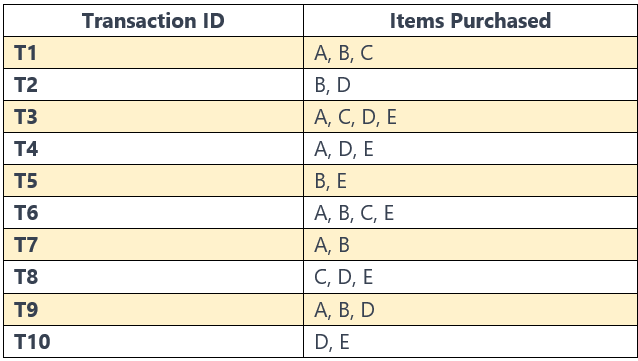

In [11]:
print("\n--- Iniciando Passo 6: Agrupamento em Lista (Pandas Workaround) ---")
transactions_list = None # Inicializar variável

# Tenta executar a conversão e agrupamento, assumindo que 'basket_items_unique' existe
try:
    # 6.1 Converter o DataFrame Polars 'basket_items_unique' para Pandas
    print("Convertendo para Pandas...")
    basket_items_unique_pd = basket_items_unique.to_pandas()
    print(f"Convertido para Pandas. Shape: {basket_items_unique_pd.shape}")

    # 6.2 Aplicar o groupby do Pandas para obter a lista de listas
    print("Agrupando produtos por pedido (Pandas)...")
    transactions_list = basket_items_unique_pd.groupby('order_id')['product_id'].apply(list).tolist()
    print(f"Agrupamento com Pandas concluído. Número de cestas (listas): {len(transactions_list)}")
    # Descomente a linha abaixo para ver as 3 primeiras cestas
    # print(transactions_list[:3])

except NameError:
    # Captura o erro se 'basket_items_unique' não existir
    print("ERRO: A variável 'basket_items_unique' não foi encontrada.")
    print("Certifique-se de que a célula anterior que a cria foi executada com sucesso.")
    transactions_list = None # Define como None

except Exception as e:
    # Captura outros erros durante a conversão ou agrupamento
    print(f"Erro durante o Passo 6 (Conversão/Agrupamento Pandas): {e}")
    transactions_list = None # Define como None

# Verificar se a etapa produziu uma lista válida antes de prosseguir
if transactions_list is None or len(transactions_list) == 0:
    print("\nAviso: Agrupamento falhou ou não resultou em transações. Verifique a execução e os dados.")
else:
    print("\nVariável 'transactions_list' (Lista de Listas Python) criada com sucesso.")
    print("Pronta para a próxima etapa (TransactionEncoder).")


--- Iniciando Passo 6: Agrupamento em Lista (Pandas Workaround) ---
Convertendo para Pandas...
Convertido para Pandas. Shape: (100196, 2)
Agrupando produtos por pedido (Pandas)...
Agrupamento com Pandas concluído. Número de cestas (listas): 96478

Variável 'transactions_list' (Lista de Listas Python) criada com sucesso.
Pronta para a próxima etapa (TransactionEncoder).


In [17]:
type(transactions_list)

list

### TransactionEncoder - Transformando a lista no formato matriz "one-hot-encoded"
- Com a lista de listas de produtos por pedido criada, iniciamos esse próximo passo; 
- As funções do MLxtend (no caso a fpgrowth), espera os dados no formato elencado no título. 

In [19]:
df_encoded_pd = None # Inicializar a variável de resultado

# Verificar se transactions_list existe e foi criada corretamente na célula anterior
if 'transactions_list' in locals() and transactions_list is not None and len(transactions_list) > 0:
    try:
        print("Instanciando e aplicando TransactionEncoder...")
        # 7.1 Instanciar o encoder
        te = TransactionEncoder()

        # 7.2 Treinar (fit) para encontrar todos os itens únicos e transformar (transform)
        # O resultado te_ary é um array NumPy booleano
        te_ary = te.fit(transactions_list).transform(transactions_list)
        print("Matriz booleana criada.")

        # 8.1 Criar DataFrame Pandas a partir do array booleano
        # As colunas serão os product_ids únicos encontrados pelo te.fit()
        df_encoded_pd = pd.DataFrame(te_ary, columns=te.columns_)
        print("\nDataFrame one-hot encoded (Pandas) criado com sucesso.")
        print(f"Shape: {df_encoded_pd.shape}")
        print(f"Número de cestas (linhas): {df_encoded_pd.shape[0]}")
        print(f"Número de produtos únicos (colunas): {df_encoded_pd.shape[1]}")
        print("\nExemplo das primeiras linhas (head):")
        print(df_encoded_pd.head())
        print("\nEste DataFrame está pronto para ser usado no FP-Growth.")

    except Exception as e:
        print(f"Erro durante a aplicação do TransactionEncoder ou criação do DataFrame: {e}")
        df_encoded_pd = None # Indica que houve erro

else:
    print("ERRO: 'transactions_list' não foi encontrada, está vazia ou não foi criada corretamente.")
    print("Execute a célula anterior (Passo 6) com sucesso primeiro.")

# Verificar se a etapa funcionou antes de prosseguir para a próxima célula
if df_encoded_pd is None or df_encoded_pd.empty:
    print("\nAviso: Falha ao criar DataFrame codificado. Análise não pode prosseguir.")
else:
     print("\nDataFrame 'df_encoded_pd' gerado com sucesso.")

Instanciando e aplicando TransactionEncoder...
Matriz booleana criada.

DataFrame one-hot encoded (Pandas) criado com sucesso.
Shape: (96478, 32216)
Número de cestas (linhas): 96478
Número de produtos únicos (colunas): 32216

Exemplo das primeiras linhas (head):
   00066f42aeeb9f3007548bb9d3f33c38  00088930e925c41fd95ebfe695fd2655  \
0                             False                             False   
1                             False                             False   
2                             False                             False   
3                             False                             False   
4                             False                             False   

   0009406fd7479715e4bef61dd91f2462  000b8f95fcb9e0096488278317764d19  \
0                             False                             False   
1                             False                             False   
2                             False                             False   
3     

#### 🚨 Alerta - Matriz Gigante! 
- Devido o processo de TransactionEncoder criar uma matriz gigante, devemos tomar cuidados com o processamento da mesma; 
- Pode ocorrer esgotamento do processamento da máquina, acarretando na falta de memória alocada para o processo; 
- Em casos extremos, precisamos realizar uma redução de dimensionalidade, seguindo boas práticas para não perder tanta informação. 

In [24]:
df_encoded_pd.shape

(96478, 32216)